<a href="https://colab.research.google.com/github/ArvindReddyC/Sord_analysis/blob/main/Notebooks/CCN_activity_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ArvindReddyC/Sord_analysis.git

Cloning into 'Sord_analysis'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 189 (delta 80), reused 132 (delta 44), pack-reused 0
Receiving objects: 100% (189/189), 60.79 MiB | 20.63 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [ ]:
!touch test.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd 
import numpy as np 
import plotly.express as px 
import tensorflow as tf

In [3]:
main_df  = pd.read_csv('/content/drive/MyDrive/sord_data/raw_training_df.csv' , index_col = 0)
main_df.sort_values( ['User_Id','Time'], inplace=True )
main_df.reset_index( drop=True , inplace= True )
main_df.columns = [ 'Time' , 	'Angle' , 'ax' , 'ay' , 'az' , 'gx' , 'gy' , 'gz' , 'mx' , 'my' , 'mz' , 'Activity' , 	'User_Id'  ]
main_df['Activity'] = main_df['Activity'].map( { 'Sitting':0  , 'Standing' : 1 , 'Walking' : 2   } )

In [4]:
from scipy import stats

def create_segments_and_labels(df, time_steps, step):
    N_FEATURES = 10
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        angle = df['Angle'].values[i: i + time_steps]
        ax = df['ax'].values[i: i + time_steps]
        ay = df['ay'].values[i: i + time_steps]
        az = df['az'].values[i: i + time_steps]
        gx = df['gx'].values[i: i + time_steps]
        gy=  df['gy'].values[i: i + time_steps]
        gz=  df['gz'].values[i: i + time_steps]
        mx =  df['mx'].values[i: i + time_steps]
        my = df['my'].values[i: i + time_steps]
        mz  = df['mz'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        labels.append( stats.mode(df['Activity'][i: i + time_steps])[0][0] ) 
        segments.append([angle, ax , ay , az , gx , gy , gz , mx , my , mz ])
    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    label = np.asarray(labels)
    return (reshaped_segments,label)

reshaped_x , labels   =  create_segments_and_labels(main_df, 64 , 32)
print(reshaped_x.shape)
print( labels.shape )

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( reshaped_x , labels , test_size=0.25, random_state=42)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print( f' X_train : {X_train.shape} \n X_test : {X_test.shape} \n y_train : {y_train.shape} \n y_test : {y_test.shape}  ' )

(37118, 64, 10)
(37118,)
 X_train : (27838, 64, 10) 
 X_test : (9280, 64, 10) 
 y_train : (27838, 3) 
 y_test : (9280, 3)  


>p=False #1: 99.817
[[99.81681108474731]] [False]
Param=False: 99.817% (+/-0.000)


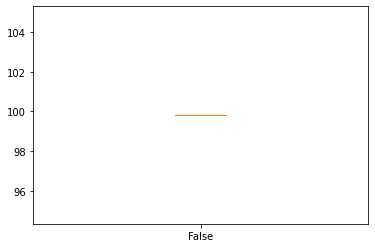

In [83]:
# cnn model with standardization
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D



# standardize data
def scale_data(trainX, testX, standardize):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	# flatten train and test
	flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
	flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
	# standardize
	if standardize:
		s = StandardScaler()
		# fit on training data
		s.fit(longX)
		# apply to training and test data
		longX = s.transform(longX)
		flatTrainX = s.transform(flatTrainX)
		flatTestX = s.transform(flatTestX)
	# reshape
	flatTrainX = flatTrainX.reshape((trainX.shape))
	flatTestX = flatTestX.reshape((testX.shape))
	return flatTrainX, flatTestX

def evaluate_model(trainX, trainy, testX, testy, param):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# scale data
	trainX, testX = scale_data(trainX, testX, param)
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.3))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	opt = tf.keras.optimizers.Adam( learning_rate = 0.001 )
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy,model
 
# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_standardize')

# run an experiment
def run_experiment(params = [False] ,   repeats=1):
	# load data
	my_model = []
	trainX, trainy, testX, testy = X_train, y_train , X_test , y_test
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score,my_model = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%s #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)
	return my_model

# # run the experiment
# n_params = [False, True]
my_model = run_experiment()

## Testing on the data sent by Reza

In [9]:
import pandas as pd
import numpy as np
import plotly.express as px
pd.options.mode.chained_assignment = None


In [10]:
main_df.columns


def tran(x):
    y = x[1:-1]
    return y.split(',')

def data_wrangle( df ):
    sample = df[['timestamp','raw_sensor_data']];
    sample['parameters'] = sample.raw_sensor_data.apply(tran);
    main = pd.DataFrame( sample.parameters.to_list() , columns = ['Time', 'Angle', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz'] );
    main['timestamp'] = sample['timestamp'];
    main.drop( 'Time' , axis = 1 , inplace = True );
    main.set_index('timestamp' , inplace=True);
    return main;

def encapsule(df):
    display(df.head(5))
    print( f'shape of df = {df.shape}' )
    return df

def change_time(some_df):
  some_df = some_df.reset_index()
  #display(some_df.head(5))
  some_df['timestamp'] = pd.to_datetime(some_df['timestamp'] , utc= True )
  #display(some_df.dtypes)
  some_df['timestamp'] = some_df['timestamp'].dt.tz_convert('Australia/Melbourne')
  some_df.set_index('timestamp', inplace = True)
  some_df[some_df.columns.drop('Activity')] = some_df[some_df.columns.drop('Activity')].applymap( pd.to_numeric )
  return some_df    

In [77]:
Standing_df = encapsule(data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/Standing.xlsx')))
Standing_df.sort_index(inplace = True)

walk1 = encapsule(data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/Walking.xlsx')))
walk1.sort_index(inplace = True)

walk2 = encapsule(data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/Walking2.xlsx')))
walk2.sort_index(inplace = True)

Sitting = encapsule(data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/Sitting.xlsx')))
Sitting.sort_index(inplace = True)



Standing_df['Activity'] = 'Standing'
walk1['Activity'] = 'Walking'
walk2['Activity'] = 'Walking'
Sitting['Activity'] = 'Sitting'

combined = pd.concat([ Standing_df,walk1,walk2,Sitting ])


combined.drop(combined.iloc[np.where( combined == '-' )[0] , 9].index, inplace=True)
combined = change_time(combined)
combined.Angle = (180 -  combined.Angle)


combined = combined.sort_index()
combined.Activity = combined.Activity.map( { 'Sitting':0  , 'Standing' : 1 , 'Walking' : 2   })
reza_train , lebels  = create_segments_and_labels(combined ,  64 , 32)
print(reza_train.shape)
# print(lebels.shape)
# lebels = to_categorical(lebels)

,Angle,ax,ay,az,gx,gy,gz,mx,my,mz
timestamp,,,,,,,,,,
2022-02-22 07:28:10.09,86.84128590762317,-9.74,0.08,-0.48,-0.8125,0,-0.25,-47.25,12.1875,12.
2022-02-22 07:28:00.389,77.38684258164965,-9.68,-0.8,-2.16,1.25,6.1875,-6.0625,-49.875,8.375,5.062
2022-02-22 07:28:00.391,77.08711111657357,-9.39,-0.33,-2.27,-2.5625,7.75,-4.625,-48.75,8.375,5.062
2022-02-22 07:28:00.392,76.84706725685965,-9.57,-0.76,-2.33,2,4.6875,-3.25,-49.5,8,5.
2022-02-22 07:28:00.394,76.66688025469716,-9.65,-0.33,-2.26,4.1875,9.75,-4.3125,-49.5,8.375,5.


shape of df = (15322, 10)


,Angle,ax,ay,az,gx,gy,gz,mx,my,mz
timestamp,,,,,,,,,,
2022-02-22 05:24:36.038,44.91433068229931,-2.25,2.98,-0.82,-21.6875,-88.375,-13.5625,-44.25,3.25,-2.
2022-02-22 05:24:14.591,59.11842410102288,4.54,16.69,8.98,-370.25,176.875,35,-58.25,-2,-0.562
2022-02-22 05:24:15.632,57.46905078477761,-3.45,-13.73,-2.4,333.625,-144.625,-96.8125,-57.875,-3.375,-4.2
2022-02-22 05:24:15.633,64.75241537573235,-19.55,-1.03,-1.6,163.6875,-106.5,51.375,-57.875,-4.5,4.687
2022-02-22 05:24:15.634,66.67673748035364,-7.4,-4.11,-0.51,-42.625,-104.25,18.6875,-57.875,-4.5,4.687


shape of df = (8096, 10)


,Angle,ax,ay,az,gx,gy,gz,mx,my,mz
timestamp,,,,,,,,,,
2022-02-22 06:04:10.477,69.45025954274941,-37.78,7.46,-3.89,70.75,-81.375,72.75,-35.0625,16.875,-43.37
2022-02-22 06:04:00.037,103.99497143843135,-15.53,-2.3,-3.18,-6.375,238.125,45.125,-57.25,-11.5,-9.562
2022-02-22 06:04:00.04,95.15186664560125,-17.21,-7.36,8.42,-72.6875,182.375,-21.6875,-54.875,-10.25,-17.87
2022-02-22 06:04:00.042,89.64920742406,-16.82,-3.09,-3.19,-71.9375,180.125,-41.6875,-50.1875,-8.75,-26.187
2022-02-22 06:04:00.044,82.495027065881,-17.79,2.93,-2.47,-62.625,183.4375,-45.375,-50.1875,-8.75,-26.187


shape of df = (13078, 10)


,Angle,ax,ay,az,gx,gy,gz,mx,my,mz
timestamp,,,,,,,,,,
2022-02-22 05:31:16.187,9.696321064600399,-1.58,0.58,-9.97,0,-0.25,0.5625,-8.875,-60.0625,-6.2
2022-02-22 05:31:16.191,9.696321064600399,-1.54,0.65,-10.04,0.0625,0.3125,0.5625,-8.875,-60.0625,-6.2
2022-02-22 05:31:16.193,9.696321064600399,-1.53,0.65,-9.62,0.875,-0.625,0.25,-8.875,-60.0625,-6.2
2022-02-22 05:31:16.194,9.696321064600399,-1.59,0.49,-9.74,-1.0625,0,0.375,-8.1875,-58.25,-7.
2022-02-22 05:31:16.194,10.037503980135401,-1.42,0.69,-9.84,-0.3125,0.3125,0.5625,-8.1875,-55.6875,-12.


shape of df = (45702, 10)
(2554, 64, 10)


In [19]:
preds = my_model.predict( reza_train )

In [20]:
preds_df  = pd.DataFrame(preds)
preds_df.dropna( how = 'all' , inplace = True  )

predds = []
for i in  preds_df.index:
   predds.append(np.argmax( preds_df.loc[i,] ))



In [21]:
list_of_preds = []
for each in preds:
    list_of_preds.append(np.argmax(each) )

In [22]:
from  collections import Counter
print( 'Original := ' ,  Counter(lebels[preds_df.index]))

print( 'Predictions := ' , Counter(predds))

Original :=  Counter({0: 1399, 2: 507, 1: 473})
Predictions :=  Counter({0: 1330, 1: 544, 2: 505})


In [23]:
from sklearn.metrics import accuracy_score
print( accuracy_score(  predds , lebels[preds_df.index]  ) * 100)


97.01555275325767


## Test 2 

In [71]:
Sitting1 = data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/test_set_2/Sitting_LoR_2502.xlsx'))
Sitting1.sort_index(inplace = True)

Sitting2 = data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/test_set_2/Sitting_RoL_2502.xlsx'))
Sitting2.sort_index(inplace = True)

Sitting3 = data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/test_set_2/Sitting_normal-legover_2502.xlsx'))
Sitting3.sort_index(inplace = True)

Sitting4 = data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/test_set_2/Sitting_normal2_2502.xlsx'))
Sitting4.sort_index(inplace = True)

Sitting5 = data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/test_set_2/Sitting_normal_2502.xlsx'))
Sitting5.sort_index(inplace = True)

Standing1 = data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/test_set_2/Standing_2502.xlsx'))
Standing1.sort_index(inplace = True)

Walking1 = data_wrangle(pd.read_excel('/content/Sord_analysis/Activity_files/test_set_2/Walking_2502.xlsx'))
Walking1.sort_index(inplace = True)


Sitting1['Activity'] = 'Sitting'
Sitting2['Activity'] = 'Sitting'
Sitting3['Activity'] = 'Sitting'
Sitting4['Activity'] = 'Sitting'
Sitting5['Activity'] = 'Sitting'

Standing1['Activity'] = 'Standing'

Walking1['Activity'] = 'Walking'


combined = pd.concat([ Sitting1,Sitting2, Sitting3,Sitting4,Sitting5,Standing1,Walking1 ])


combined.dtypes
combined.drop(combined.iloc[np.where( combined == '-' )[0] , 9].index, inplace=True)

combined[combined.columns.drop('Activity')] = combined[combined.columns.drop('Activity')].applymap( pd.to_numeric )

combined.loc[ combined[combined.Activity == 'Sitting'].index, 'Angle' ]   =   180 - combined.loc[ combined[combined.Activity == 'Sitting'].index, 'Angle' ] 
combined = change_time(combined)


combined = combined.sort_index()
combined.Activity = combined.Activity.map( { 'Sitting':0  , 'Standing' : 1 , 'Walking' : 2   })
reza_train , lebels  = create_segments_and_labels(combined ,  64 , 32)
print(reza_train.shape)



(825, 64, 10)


In [84]:
preds = my_model.predict( reza_train )

In [85]:
preds_df  = pd.DataFrame(preds)
preds_df.dropna( how = 'all' , inplace = True  )

predds = []
for i in  preds_df.index:
   predds.append(np.argmax( preds_df.loc[i,] ))

list_of_preds = []
for each in preds:
    list_of_preds.append(np.argmax(each) )


In [86]:
from  collections import Counter
print( 'Original := ' ,  Counter(lebels[preds_df.index]))

print( 'Predictions := ' , Counter(predds))

Original :=  Counter({0: 1399, 2: 507, 1: 473})
Predictions :=  Counter({0: 1321, 1: 554, 2: 504})


In [87]:
from sklearn.metrics import accuracy_score
print( accuracy_score(  predds , lebels[preds_df.index]  ) * 100)


96.55317360235392


In [88]:
fig = px.histogram( combined , x = 'Angle' , color = 'Activity')
fig.show()